In [1]:
import math
import numpy as np
from scipy import linalg
from scipy import integrate
from scipy import sparse
import scipy.optimize as optimize
import qutip as qt
import os
#from EDAspy.optimization import UMDAd
import random
import matplotlib.pyplot as plt

In [2]:
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
def idOp(dims):
    return mkSpinOp(dims, [])
def zeroOp(dims):
    d = np.prod(dims)
    return qt.Qobj(sparse.csr_matrix((d, d), dtype=np.float64), 
                       dims=[list(dims)]*2, type="oper", isherm=True) 

In [3]:
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    components = [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0]
    if components:
        return sum(components)
    else:
        return zeroOp(dims)
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    components = []
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                components.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    if components:
        return sum(components)
    else:
        return zeroOp(dims)

In [4]:
def dense(op):
    if type(op) is qt.qobj.Qobj:
        return np.asarray(op.data.todense())
    else:
        return np.asarray(op.todense())

$$
\text{Trace}({\rho(t) Z})
$$

for 

$$
\rho(t) = U(t)\rho(0) U^{\dagger}(t)
$$

In [5]:
def expvalsConstH(Heff, rho0, ops, dt, nr_steps):

    obs = np.zeros((len(ops),nr_steps))
    rhot = rho0
    U = linalg.expm(-1j*dt*Heff)
    for i in range(nr_steps):
        rhot = U @ rhot @ U.T.conjugate()
        for s in range(len(ops)):
            obs[s,i] = np.real(np.trace(ops[s] @ rhot))
                
    return obs, rhot

def expvalsPiecewiseConstHt(H0, H1, u, rho0, ops, dt):
    
    nr_steps = len(u)

    obs = np.zeros((len(ops),nr_steps))
    rhot = rho0
    for i in range(nr_steps):
        Hi = H0 + u[i] * H1
        Ui = linalg.expm(-1j*dt*Hi)
        rhot = Ui @ rhot @ Ui.T.conjugate()
        for s in range(len(ops)):
            obs[s,i] = np.real(np.trace(ops[s] @ rhot))
                
    return obs, rhot

In [6]:
def expvalGradMultiSamples(H0, H1, u, rho0, op, dt, w):
    
    nr_samples = len(w)
    nr_steps = len(u)
    assert(np.mod(nr_steps, nr_samples) == 0)
    nr_substeps = nr_steps//nr_samples
    
    U_list = []
    for i in range(nr_steps):
        Hi = H0 + u[i] * H1
        Ui, dUi = linalg.expm_frechet(-1j*dt*Hi, -1j*dt*H1)
        U_list.append((Ui,dUi))
        
    obs = 0.0
    grad = np.zeros(nr_steps)
        
    Uf = np.eye(H0.shape[0]) # after loop: UnUn-1...U1U0
    dUUf_list = [] # [dU0, dU1U0, dU2U1U0, dU3U2U1U0, ..., dUnUn-1...U1U0]
    Ub_list = []   # [Un...U2U1, Un...U2, ..., UnUn-1Un-2, UnUn-1, Un, 1]
    for j in range(nr_samples):
        m = j * nr_substeps
        n = m + nr_substeps
        Ub_list_j = []
        Ub = np.eye(H0.shape[0]) # after loop: UnUn-1...Um
        for i in range(nr_substeps):
            Ui, dUi = U_list[i + m]
            dUUf_list.append(dUi @ Uf)
            Uf = Ui @ Uf
            Ub_list_j.insert(0, Ub)
            Ub = Ub @ U_list[n-1-i][0]
        for i in range(len(Ub_list)):
            Ub_list[i] = Ub @ Ub_list[i]
        Ub_list = Ub_list + Ub_list_j
        A = rho0 @ Uf.T.conjugate() 
        #print(A.shape)
        B = A @ op
        BT = B.T
        # obs += w[j] * np.real(np.trace(Uf @ B))
        obs += w[j] * np.real(np.sum(Uf.__mul__(BT)))
        for i in range(n):
            # grad[i] += w[j] * 2 * np.real(np.trace(Ub_list[i] @ dUUf_list[i] @ B))
            grad[i] += w[j] * 2 * np.real(np.sum((Ub_list[i] @ dUUf_list[i]).__mul__(BT)))
            
    rhot = Uf @ A
        
    return obs, grad, Uf

In [7]:
# exp(iθn⋅σ) = cosθ I+i(n⋅σ)sinθ
# exp(-iudt Sx) = exp(-iudt/2 σx) = cos(udt/2) I - iσx sin(udt/2)
def expm_trotter_H1x(expiA, b1, u, ds, nr_halvings):
    dim_n = expiA.shape[0]//4
    omega = b1*u*ds/2
    c = np.cos(omega)
    s = -1j * np.sin(omega)
    expiB_1 = np.array([[c,s],[s,c]])
    dexpiB_1 = (-1j*ds*b1/2) * np.array([[s,c],[c,s]])
    expiB_12 = np.kron(expiB_1, expiB_1)
    dexpiB_12 = np.kron(dexpiB_1, expiB_1) + np.kron(expiB_1, dexpiB_1)
    # expiB = sparse.kron(expiB_12, sparse.eye(dim_n, format="csr"))
    # dexpiB = sparse.kron(dexpiB_12, sparse.eye(dim_n, format="csr"))
    # expiB = sparse.kron(sparse.csr_matrix(expiB_12), qt.fastsparse.fast_identity(dim_n))
    # dexpiB = sparse.kron(sparse.csr_matrix(dexpiB_12), qt.fastsparse.fast_identity(dim_n))
    expiB = np.kron(expiB_12, np.eye(dim_n))
    dexpiB = np.kron(dexpiB_12, np.eye(dim_n))
    U = expiA @ (expiB @ expiA)
    L = expiA @ (dexpiB @ expiA)
    for i in range(nr_halvings, 0, -1):
        L = U @ L + L @ U
        U = U @ U
    return U, L

def expvalGradMultiSamplesSplitTrotterH1x(H0, b1, u, rho0, op, dt, w, nr_halvings=4):
    
    nr_samples = len(w)
    nr_steps = len(u)
    assert(np.mod(nr_steps, nr_samples) == 0)
    nr_substeps = nr_steps//nr_samples
    
    dim = rho0.shape[0]
    
    ds = dt / 2**nr_halvings
    UA = linalg.expm(-1j*ds/2*H0) 
    
    U_list = []
    for i in range(nr_steps):
        # Hi = H0 + u[i] * H1 
        # Ui, dUi = linalg.expm_frechet(-1j*dt*Hi, -1j*dt*H1)
        Ui, dUi = expm_trotter_H1x(UA, b1, u[i], ds, nr_halvings)
        U_list.append((Ui,dUi))
        
    obs = 0.0
    grad = np.zeros(nr_steps)
        
    Uf = np.eye(dim) # after loop: UnUn-1...U1U0
    dUUf_list = [] # [dU0, dU1U0, dU2U1U0, dU3U2U1U0, ..., dUnUn-1...U1U0]
    Ub_list = []   # [Un...U2U1, Un...U2, ..., UnUn-1Un-2, UnUn-1, Un, 1]
    for j in range(nr_samples):
        m = j * nr_substeps
        n = m + nr_substeps
        Ub_list_j = []
        Ub = np.eye(dim) # after loop: UnUn-1...Um
        for i in range(nr_substeps):
            Ui, dUi = U_list[i + m]
            dUUf_list.append(dUi @ Uf)
            Uf = Ui @ Uf
            Ub_list_j.insert(0, Ub)
            Ub = Ub @ U_list[n-1-i][0]
        for i in range(len(Ub_list)):
            Ub_list[i] = Ub @ Ub_list[i]
        Ub_list = Ub_list + Ub_list_j
        A = rho0 @ Uf.T.conjugate()
        #print(A.shape)
        B = A @ op
        BT = B.T
        # obs += w[j] * np.real(np.trace(Uf @ B))
        obs += w[j] * np.real(np.sum(Uf.__mul__(BT)))
        for i in range(n):
            # grad[i] += w[j] * 2 * np.real(np.trace(Ub_list[i] @ dUUf_list[i] @ B))
            grad[i] += w[j] * 2 * np.real(np.sum((Ub_list[i] @ dUUf_list[i]).__mul__(BT)))
            
    rhot = Uf @ A
        
    return obs, grad, Uf

In [8]:
def fun(u, *args):
    H0, H1, rho0, obs, dt, w, minimize = args
    if type(H1) == float:
        ys, grad, _ = expvalGradMultiSamplesSplitTrotterH1x(H0, H1, u, rho0, obs, dt, w)
    else:
        ys, grad, _ = expvalGradMultiSamples(H0, H1, u, rho0, obs, dt, w)
    if not minimize:
        ys = -ys
        grad = -grad
           
    return ys, grad

In [9]:
def fun2(u, H0, H1, rho0, obs, dt, w, minimize):
    if type(H1) == float:
        ys, grad, _ = expvalGradMultiSamplesSplitTrotterH1x(H0, H1, u, rho0, obs, dt, w)
    else:
        ys, grad, _ = expvalGradMultiSamples(H0, H1, u, rho0, obs, dt, w)
    if not minimize:
        ys = -ys
        grad = -grad
           
    return ys

We look at a generalisation of the system studied in this paper: https://aip.scitation.org/doi/abs/10.1063/1.5131557

In [10]:
def mkSystem(b0, b1, kS, k0):

    g = 2.00231930436256 #electron g-factor
    beta = 9.274009994e-24 #bohr magneton
    hbar = 6.62607015e-34/(2*np.pi) #hbar
    mT = g*beta/hbar*1e-9 # mT -> Mrad/s

    omega0 = b0*mT
    omega1 = b1*mT
    Is = [0.5, 0.5, 0.5, 0.5, 0.5]
    indE = [0, 0, 0, 1, 1]
    hfcs = np.array([0.2, 0.5, 1.0, 0.2, 0.3]) * mT # mT -> Mrad/s
    jex = 1 * 2*math.pi

    dims = [2, 2] + [round(2*Is[i]+1) for i in range(len(Is))]
    Hhfc = sum(mkH12(dims, indE[i], i+2, np.eye(3)*hfcs[i]) for i in range(len(hfcs)))
    Hzee = mkH1(dims, 0, [0,0,omega0]) + mkH1(dims, 1, [0,0,omega0])
    Hex = -jex * (1/2*mkSpinOp(dims, []) + mkH12(dims, 0, 1, 2*np.identity(3)))
    H0 = Hhfc + Hzee + Hex
    H1 = mkH1(dims, 0, [omega1,0,0]) + mkH1(dims, 1, [omega1,0,0])
    Ps = 0.25 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.eye(3))
    H = H0 - 1j * kS/2 * Ps
    rho0 = Ps/Ps.tr()
    H, H1, rho0 = [dense(op) for op in (H, H1, rho0)]
    Ps = Ps.data

    sys = {
        'Is': Is,
        'indE': indE,
        'hfcs': hfcs,
        'jex': jex,
        'omega0': omega0,
        'omega1': omega1,
        'kS': kS,
        'k0': k0
    }

    return H, H1, omega1, rho0, Ps, sys

In [11]:
def optimizeYield(name, b0, b1, kS, k0, nr_cycles, nr_steps, nr_samples, eda_opt):

    # Optimize singlet probability after nr_steps steps of dt usind L-BFGS-B

    dt = 0.001
    nr_total = max(math.ceil(2/k0) * 1000, nr_cycles*nr_steps)
    nr_iter = 200
    minimize = True

    t_sampled = (np.arange(nr_samples) + 1) * (nr_steps//nr_samples)*dt # without t0
    # w = np.ones(nr_samples)
    w = np.exp(-t_sampled*k0) * k0 * (nr_steps//nr_samples)*dt

    H, H1, omega1, rho0, Ps, sys = mkSystem(b0, b1, kS, k0)

    rho = rho0
    
    #stats = []
    uopt_all = []
    for i in range(nr_cycles):
        u0 = np.random.randn(nr_steps)
        ind = np.where(np.abs(u0) > 1)[0]
        u0[ind] = np.sign(u0[ind])
        
        if eda_opt:
            eda = UMDAd(size_gen=30, max_iter=100, dead_iter=10, n_variables=8, alpha=0.5, vector=None,
            lower_bound=0.2, upper_bound=0.9, elite_factor=0.2, disp=True)

            eda_result = eda.minimize(cost_function=fun2(u0, H, H1, rho0, obs, dt, w, minimize), output_runtime=True)
            
            """
            CHANGE THIS LINE ABOVE WITH THE CORRECT OBS!!!!!
            """
            
            #eda_result = eda.minimize(cost_function=fun2(u0, H, H1, rho0, obs = np.eye(128), dt, w, minimize),
            #                          output_runtime= True)
        else:
            opt = optimize.minimize(fun, u0, 
                        args=(H, omega1, rho, Ps, dt, w, minimize),
                        method='L-BFGS-B',
                        jac=True, bounds=[(-1,1) for _ in range(len(u0))],
                        options={'disp': 0, 'maxcor': 60, 'ftol': 1e-6, 'gtol': 1e-7, 'maxiter': nr_iter})
            print(opt.message)
            print(opt.fun)
        
        
        u = opt.x
        uopt_all.append(u)
        #stats.append((opt.fun, opt.nit, opt.nfev, opt.success))
        
        ps, rho = expvalsPiecewiseConstHt(H, H1, u, rho, [Ps], dt)
        
    u = np.concatenate(uopt_all)
    u = np.concatenate((u, np.zeros(nr_total-len(u))))
    t = np.arange(len(u))*dt
    ps, _ = expvalsPiecewiseConstHt(H, H1, u, rho0, [Ps], dt)
    ps = ps[0]
    ys = integrate.simps(ps*k0*np.exp(-k0*t))*dt
    ps0, _ = expvalsConstH(H, rho0, [Ps], dt, nr_total)
    ps0 = ps0[0]
    ys0 = integrate.simps(ps0*k0*np.exp(-k0*t))*dt
    print("{} x {} @ {} : {} vs. {}".format(nr_cycles, nr_steps, nr_samples, ys, ys0))
    
    np.savez(name, sys=sys, u=u, 
             nr_cycles=nr_cycles, nr_steps=nr_steps, nr_samples=nr_samples, nr_iter=nr_iter, minimize=minimize,
             ys=ys, ys0=ys0, ps=ps, ps0=ps0) #stats=stats)

    return ys, ps #, stats

### Eduardo's trials: 

In [12]:
nr_cycles = 100
nr_steps = 100
dt = 0.001
nr_samples = 100
b0 = 0.05 # mT (this is the geomagnetic field, relavant to avian magnetoreception)
b1 = 0.25 # mT, free to try different parameters here
k0 = 1.0 # 1/us
kS = 1.0 # 1/us

nr_total = max(math.ceil(2/k0) * 1000, nr_cycles*nr_steps)
nr_iter = 200
minimize = True

t_sampled = (np.arange(nr_samples) + 1) * (nr_steps//nr_samples)*dt # without t0
# w = np.ones(nr_samples)
w = np.exp(-t_sampled*k0) * k0 * (nr_steps//nr_samples)*dt

H, H1, omega1, rho0, Ps, sys = mkSystem(b0, b1, kS, k0)

rho = rho0


for i in range(nr_cycles):
    u0 = np.random.randn(nr_steps)
    ind = np.where(np.abs(u0) > 1)[0]
    u0[ind] = np.sign(u0[ind])

obs = np.eye(128,128)
#fun(u0, H, H1, rho0, obs, dt, w, minimize)
args = (H, H1, rho0, obs, dt, w, minimize)
fun2(u0, *args)

0.09296128095588703

### One iteration of genetic algorithm:

In [13]:
import time as time
time.time()

1682294530.1534255

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [79]:
grid_genes = [5,15,25]
grid_daughters = [10,20,30]
grid_change = [0.01,0.05,0.1,0.5]

for u,v,w in zip(grid_genes,grid_daughters,grid_change):
    print("Genes {}, daughters {}, change {}".format(u,v,w))



Genes 5, daughters 10, change 0.01
Genes 15, daughters 20, change 0.05
Genes 25, daughters 30, change 0.1


In [248]:
"""Randomize array"""
#number_genes, number_daughters, change = 25, 30, 0.01
#number_generations = 10

#patience = 5

validation_generations = 15

setup = {"genes":[5,15,25], "offspring":[10,20], "changes":[0.01,0.1, 0.2]}
combinations = [setup["genes"], setup["offspring"], setup["changes"]]
combinations = list(itertools.product(*combinations))

initial_guess = u0

history = np.zeros((len(combinations), validation_generations)) #Here we save the cost function values
history[:,0] = fun2(u0,*args)

generations = np.zeros((len(combinations), len(initial_guess), validation_generations + 1))
generations[:,:,0] = u0

initial_cost = fun2(u0,*args)
best_cost = 1000 # To save the best one
best_u0 = u0

counter = 1 #Counter for combinations

with tf.device("/GPU:0"):

    for combination in combinations:
        number_genes, number_offspring, number_change = combination[0], combination[1], combination[2]

        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Combination {} / {}".format(counter, len(combinations)))
        print("Combination of: {} genes, {} offsprings and {} change".format(number_genes, number_offspring, number_change))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        initial_guess = u0 #Initial guess the same for all combinations 

        for generation in range(validation_generations):
            print("Generation {} / {}".format(generation, validation_generations-1))
            daughters = []
            daughters_cost = []

            for daughter in range(number_offspring):
                random_indexes = [1]*number_genes + [0]*(len(u0)-number_genes) 
                random_indexes = random.shuffle(random_indexes)
                random_changes = np.random.uniform(low=-number_change, high = number_change, size = (len(u0),) )
                v = generations[combinations.index(combination), : , generation] #Auxiliary variable
                v[random_indexes] = v[random_indexes] + random_changes

                #We now normalize from -1 to 1 in case we have a higher v
                ind = np.where(np.abs(v) > 1)[0]
                v[ind] = np.sign(v[ind]) #We normalize the vector from -1 to 1

                # We now save the daughter to the list
                daughters.append(v)

                # We now measure which one is the best of all

            for daughter in daughters: 
                daughters_cost.append(fun2(daughter, *args))

            winner_cost = min(daughters_cost)
            winner_daughter = daughters[daughters_cost.index( winner_cost )]

            if winner_cost < best_cost:
                best_cost = winner_cost
                best_u0 = winner_daughter
                configurations = [number_genes, number_offspring, number_change]
                print("BEST OVERALL!!!!!!!!!!!!")


            initial_guess = winner_daughter



            history[combinations.index(combination), generation ] = winner_cost
            generations[combinations.index(combination), : , generation + 1] = winner_daughter
            #generations = np.zeros((len(combinations), len(initial_guess), number_generations + 1))


            print("Best cost: ",winner_cost)
            print("Cost change: ", history[combinations.index(combination), generation]-history[combinations.index(combination), generation - 1])
            print("===============================================================================")

        counter = counter + 1 #Counter just to print how much
        

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combination 1 / 18
Combination of: 5 genes, 10 offsprings and 0.01 change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Generation 0 / 14
BEST OVERALL!!!!!!!!!!!!
Best cost:  0.09296123295974511
Cost change:  0.09296123295974511
Generation 1 / 14
BEST OVERALL!!!!!!!!!!!!
Best cost:  0.09296119985168806
Cost change:  -3.310805704592745e-08
Generation 2 / 14
BEST OVERALL!!!!!!!!!!!!
Best cost:  0.09296116704973253
Cost change:  -3.2801955526795545e-08
Generation 3 / 14
Best cost:  0.09296118669659607
Cost change:  1.9646863538835824e-08
Generation 4 / 14
BEST OVERALL!!!!!!!!!!!!
Best cost:  0.09296116553810965
Cost change:  -2.1158486421257727e-08
Generation 5 / 14
BEST OVERALL!!!!!!!!!!!!
Best cost:  0.09296107960108782
Cost change:  -8.593702183201657e-08
Generation 6 / 14
Best cost:  0.0929611578142646
Cost change:  7.821317678236017e-08
Generation 7 / 14
Best cost:  0.092

BEST OVERALL!!!!!!!!!!!!
Best cost:  0.09295726308568074
Cost change:  -3.692046895154011e-07
Generation 14 / 14
Best cost:  0.09295822243140024
Cost change:  9.593457195034016e-07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combination 4 / 18
Combination of: 5 genes, 20 offsprings and 0.01 change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Generation 0 / 14
Best cost:  0.09296131022143428
Cost change:  0.09296131022143428
Generation 1 / 14
Best cost:  0.09296155793160592
Cost change:  2.477101716386043e-07
Generation 2 / 14
Best cost:  0.0929612247977087
Cost change:  -3.3313389721789655e-07
Generation 3 / 14
Best cost:  0.09296128890535144
Cost change:  6.4107642736011e-08
Generation 4 / 14
Best cost:  0.09296137030861379
Cost change:  8.140326235306361e-08
Generation 5 / 14
Best cost:  0.09296138331993807
Cost change:  1.3011324281886338e-08
Generation 6 / 14
Best cost:  0.09296143801924586
Cost change:  5.46993

Best cost:  0.09295736278724508
Cost change:  -6.617521280394278e-07
Generation 14 / 14
Best cost:  0.09295802773012556
Cost change:  6.649428804794688e-07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combination 7 / 18
Combination of: 15 genes, 10 offsprings and 0.01 change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Generation 0 / 14
Best cost:  0.09296118887763923
Cost change:  0.09296118887763923
Generation 1 / 14
Best cost:  0.09296122090705358
Cost change:  3.202941435687112e-08
Generation 2 / 14
Best cost:  0.09296118707411508
Cost change:  -3.3832938506339616e-08
Generation 3 / 14
Best cost:  0.09296115991633765
Cost change:  -2.7157777429676067e-08
Generation 4 / 14
Best cost:  0.09296120581426931
Cost change:  4.589793166365208e-08
Generation 5 / 14
Best cost:  0.09296118645916276
Cost change:  -1.9355106545271283e-08
Generation 6 / 14
Best cost:  0.09296123505407705
Cost change:  4.8594914286992363e-08
Ge

Best cost:  0.09295994700267553
Cost change:  7.502070553527806e-07
Generation 14 / 14
Best cost:  0.09295914497318931
Cost change:  -8.020294862132182e-07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combination 10 / 18
Combination of: 15 genes, 20 offsprings and 0.01 change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Generation 0 / 14
Best cost:  0.09296135466476031
Cost change:  0.09296135466476031
Generation 1 / 14
Best cost:  0.09296108726216148
Cost change:  -2.6740259882751527e-07
Generation 2 / 14
Best cost:  0.09296134624850073
Cost change:  2.589863392493674e-07
Generation 3 / 14
Best cost:  0.09296093188596442
Cost change:  -4.14362536310664e-07
Generation 4 / 14
Best cost:  0.0929608601091305
Cost change:  -7.177683392090017e-08
Generation 5 / 14
Best cost:  0.09296089441483535
Cost change:  3.4305704846304685e-08
Generation 6 / 14
Best cost:  0.09296118606360113
Cost change:  2.916487657766975e-07
Gener

Best cost:  0.09296006824444152
Cost change:  -1.0733343448476873e-06
Generation 14 / 14
Best cost:  0.09296365558321026
Cost change:  3.5873387687485048e-06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combination 13 / 18
Combination of: 25 genes, 10 offsprings and 0.01 change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Generation 0 / 14
Best cost:  0.09296124779866823
Cost change:  0.09296124779866823
Generation 1 / 14
Best cost:  0.0929613884534059
Cost change:  1.4065473767643777e-07
Generation 2 / 14
Best cost:  0.09296120779676527
Cost change:  -1.806566406331589e-07
Generation 3 / 14
Best cost:  0.09296104176066816
Cost change:  -1.6603609710730272e-07
Generation 4 / 14
Best cost:  0.09296099719943594
Cost change:  -4.456123221807662e-08
Generation 5 / 14
Best cost:  0.09296095469637572
Cost change:  -4.250306022413053e-08
Generation 6 / 14
Best cost:  0.09296101766428383
Cost change:  6.296790810988995e-08
G

Best cost:  0.09296049468428903
Cost change:  1.2270529429758703e-06
Generation 14 / 14
Best cost:  0.09296007265448802
Cost change:  -4.2202980100880527e-07
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Combination 16 / 18
Combination of: 25 genes, 20 offsprings and 0.01 change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Generation 0 / 14
Best cost:  0.09296121679477429
Cost change:  0.09296121679477429
Generation 1 / 14
Best cost:  0.09296164070932554
Cost change:  4.2391455125356803e-07
Generation 2 / 14
Best cost:  0.09296148043871758
Cost change:  -1.602706079656402e-07
Generation 3 / 14
Best cost:  0.09296123377720315
Cost change:  -2.4666151442198636e-07
Generation 4 / 14
Best cost:  0.09296116732786291
Cost change:  -6.644934023858351e-08
Generation 5 / 14
Best cost:  0.09296111456848342
Cost change:  -5.275937949023035e-08
Generation 6 / 14
Best cost:  0.0929608713684605
Cost change:  -2.4320002292577136e-07

Best cost:  0.09295771146718433
Cost change:  -2.2300334019675905e-07
Generation 14 / 14
Best cost:  0.09295830275736648
Cost change:  5.912901821503169e-07


## Hypervalidation is done!

Best cost:  0.09295707354082346
Winner configurations:  [25, 10, 0.1]


Text(0, 0.5, 'Pulse Amplitude')

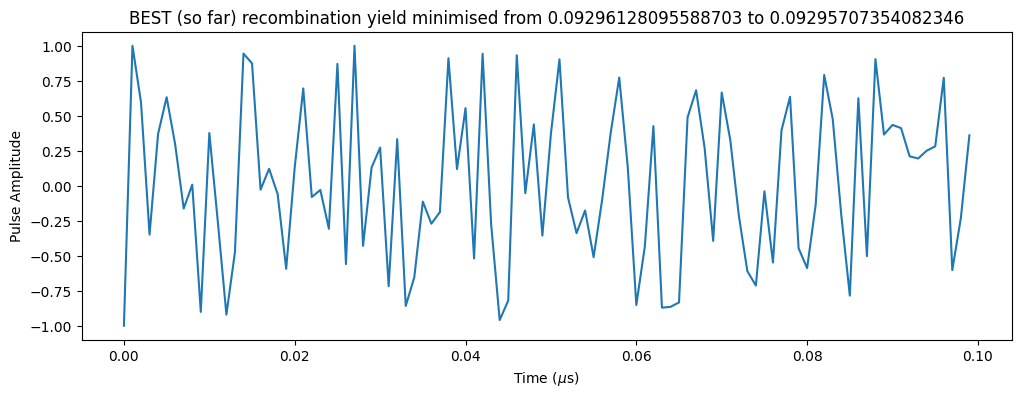

In [249]:
print("Best cost: ", best_cost)
print("Winner configurations: ", configurations)
#print("Best u0: ",best_u0)

t = np.arange(len(best_u0)) * 0.001
plt.figure(figsize=(12,4))
plt.plot(t,best_u0)
plt.title("BEST (so far) recombination yield minimised from {} to {}".format(initial_cost, best_cost))
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Pulse Amplitude")

In [250]:
### Hypervalidation is done! 
#print("Best cost: ", min(history[:,-1]) )
#indice = history[:,-1].argmin()
#print("Setup of {} genes, {} offspring and a change of {}".format(combinations[indice][0],combinations[indice][1],combinations[indice][2] ))

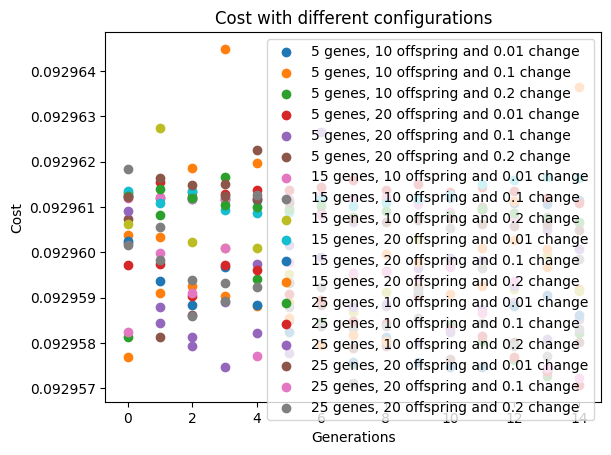

In [251]:
for u in range(  np.array(history).shape[0]  ):
    plt.scatter(x = range(np.array(history).shape[1]), 
                y = history[u,:], 
                label = "{} genes, {} offspring and {} change".format(combinations[u][0],combinations[u][1],combinations[u][2])   )
    plt.legend()
    plt.xlabel("Generations")
    plt.ylabel("Cost")
    plt.title("Cost with different configurations")

## Now we train normally! 

In [252]:
"""Randomize array"""
initial_time = time.time()
number_genes, number_daughters, change = configurations[0], configurations[1], configurations[2]
number_generations = 40

initial_guess = best_u0 #We carry the result from our previous hypervalidation result
best_cost = 10000

history = []
history.append(fun2(initial_guess,*args))

generations = []

with tf.device("/GPU:0"):
    for generation in range(number_generations):
        print("Generation {} / {} ".format(generation, number_generations-1))

        daughters = []
        daughters_cost = []

        for u in range(number_daughters):
            random_indexes = [1]*number_genes + [0]*(len(u0)-number_genes)
            random_indexes = random.shuffle(random_indexes)
            random_changes = np.random.uniform(low=-change, high=change, size=(len(initial_guess),))
            v = initial_guess.copy() #Auxiliary variable
            v[random_indexes] = v[random_indexes] + random_changes

            #We now normalize from -1 to 1 in case we have a higher v
            ind = np.where(np.abs(v) > 1)[0]
            v[ind] = np.sign(v[ind])

            # We now save the daughter to the list
            daughters.append(v)

            #We now measure which one is best out of all of these

        for daughter in daughters:
            daughters_cost.append(fun2(daughter, *args))

        winner_cost = min(daughters_cost)
        winner_daughter = daughters[daughters_cost.index( winner_cost )]

        initial_guess = winner_daughter
        
        if winner_cost < best_cost:
            best_cost = winner_cost
            best_u0 = winner_daughter
            

        history.append(winner_cost)
        generations.append(winner_daughter)
        print("Best cost: ",winner_cost)
        print("Cost change: ", history[generation]-history[generation-1])
        print("==========================================")

Generation 0 / 39 
Best cost:  0.09295701283075877
Cost change:  6.071006468377771e-08
Generation 1 / 39 
Best cost:  0.09295691126409818
Cost change:  -6.071006468377771e-08
Generation 2 / 39 
Best cost:  0.09295686921910408
Cost change:  -1.0156666059579766e-07
Generation 3 / 39 
Best cost:  0.09295684370912406
Cost change:  -4.204499409743434e-08
Generation 4 / 39 
Best cost:  0.09295675024989966
Cost change:  -2.5509980017268674e-08
Generation 5 / 39 
Best cost:  0.09295669341838035
Cost change:  -9.345922440118226e-08
Generation 6 / 39 
Best cost:  0.0929566639971786
Cost change:  -5.683151931001884e-08
Generation 7 / 39 
Best cost:  0.09295662417424255
Cost change:  -2.9421201752644066e-08
Generation 8 / 39 
Best cost:  0.09295661186920831
Cost change:  -3.9822936045985635e-08
Generation 9 / 39 
Best cost:  0.0929566357380035
Cost change:  -1.2305034241544277e-08
Generation 10 / 39 
Best cost:  0.09295659801896922
Cost change:  2.3868795190340464e-08
Generation 11 / 39 
Best cost

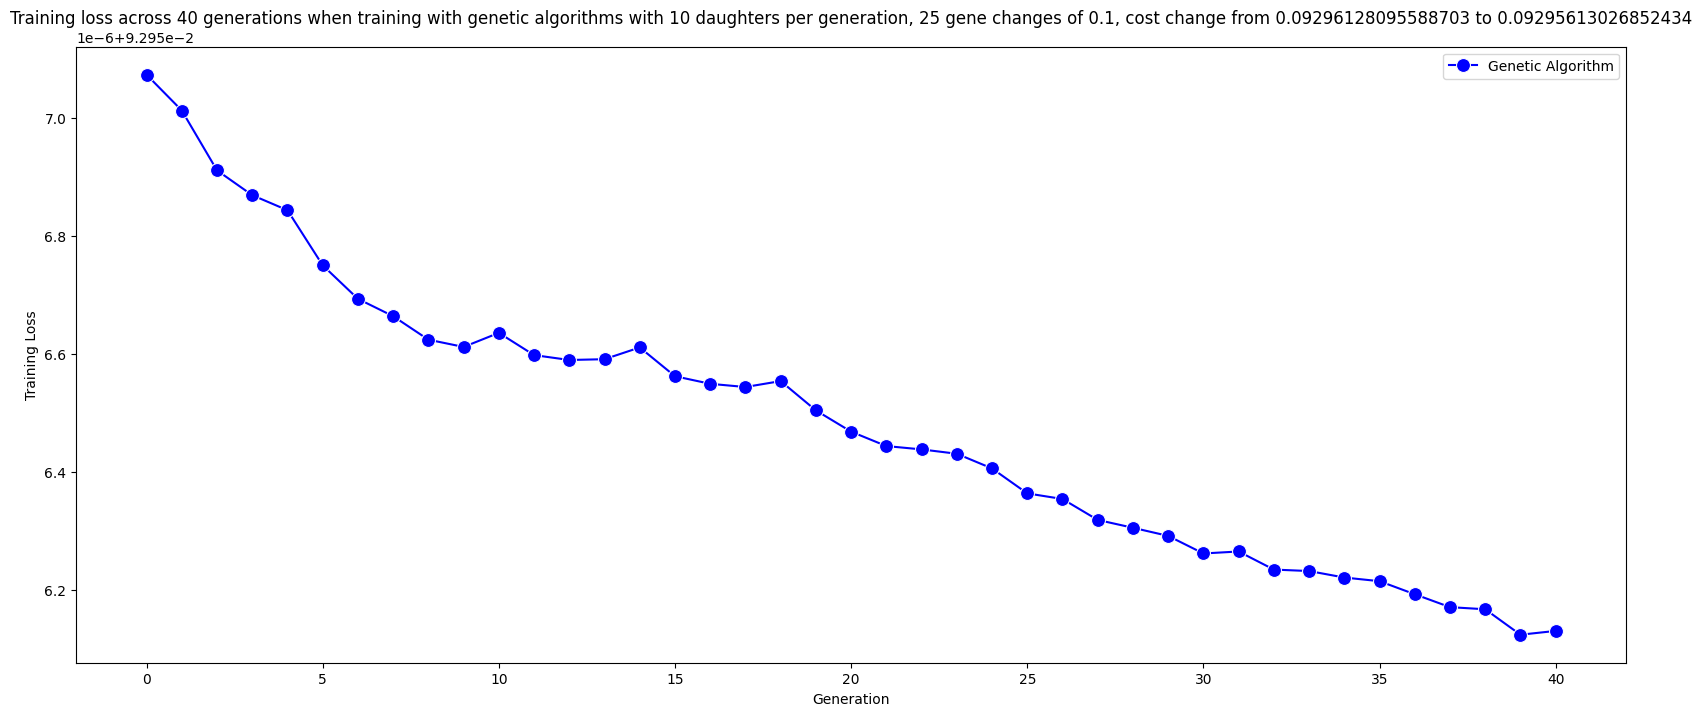

In [256]:
import seaborn as sns
name = "Training loss across {} generations when training with genetic algorithms with {} daughters per generation, {} gene changes of {}, cost change from {} to {}".format(number_generations, number_daughters, number_genes,change, initial_cost, history[-1])
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = range(len(history)), y = history, label = "Genetic Algorithm", marker = "o", color = "blue", markersize = 10)
ax.set_title(name)
ax.set_ylabel('Training Loss')
ax.set_xlabel('Generation')
ax.legend()
plt.savefig("Training_loss_genetic.pdf")
plt.show()

In [255]:
history[-1]

0.09295613026852434

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


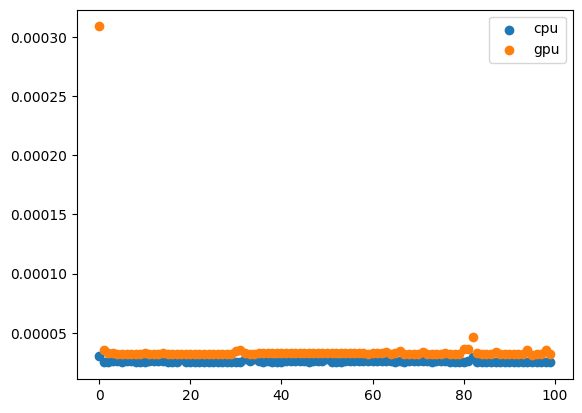

In [22]:
cpu = []
gpu = []

#n = 1000000

n = 100
a = np.ones(n, dtype = np.float64)

for v in range(n):
    start = timer()
    func(a)
    cpu.append(timer()-start)
    
    start = timer()
    with tf.device("/GPU:0"):
        func(a)
        gpu.append(timer()-start)
        

plt.scatter(range(n), cpu, label = "cpu")
plt.scatter(range(n), gpu, label = "gpu")
plt.legend()

In [24]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
def main():
    eda_opt = False
    b0 = 0.05 # mT (this is the geomagnetic field, relavant to avian magnetoreception)
    b1 = 0.25 # mT, free to try different parameters here
    k0 = 1.0 # 1/us
    kS = 1.0 # 1/us

    jobs = []
    nr_controlled = 100  # free to try different parameters here, try smaller if too computationally intensive
    for nr_steps in [100]: # free to try different parameters here, same as above
        for sampling_interval in [100]: # free to change parameters here, note relation to nr_samples
            if nr_steps % sampling_interval != 0:
                continue
            nr_samples = nr_steps // sampling_interval
            nr_cycles = nr_controlled // nr_steps
            name = "qosf_{}x{}@{}".format(nr_cycles, nr_steps, nr_samples)
            jobs.append((name, b0, b1, kS, k0, nr_cycles, nr_steps, nr_samples, eda_opt))

    for job in jobs:
        optimizeYield(*job)

In [26]:
with tf.device("/GPU:0"):
    main()

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
0.03160245007995208
1 x 100 @ 1 : 0.25772259772440026 vs. 0.2587236686524376


### Visualization of a specific configuration:

['sys', 'u', 'nr_cycles', 'nr_steps', 'nr_samples', 'nr_iter', 'minimize', 'ys', 'ys0', 'ps', 'ps0']


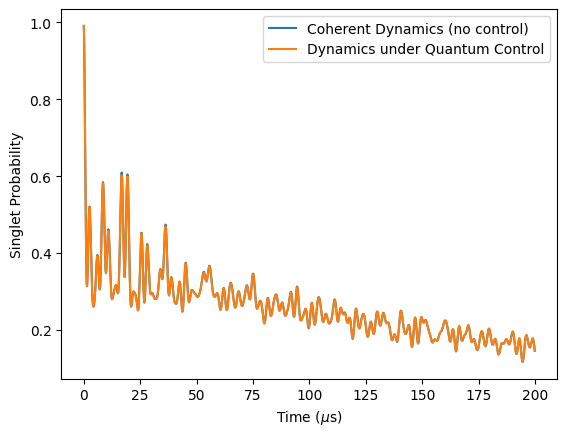

In [27]:
import matplotlib.pyplot as plt

#npzfile = r"C:/Users/eduar/Desktop/Escuela/Calgary_GRAD/Geneticists/1/qosf_4x500@5.npz"

npzfile = r"C:/Users/eduar/Desktop/Escuela/Calgary_GRAD/Geneticists/1/qosf_1x100@1.npz" #New one!


dat = np.load(npzfile)
fields = dat.files
print(fields)

dt = 0.1
u_opt = dat["u"]
tpts = np.arange(len(u_opt)) * dt
ps0 = dat["ps0"]
ps = dat["ps"]
plt.plot(tpts, ps0)
plt.plot(tpts, ps)
plt.legend(["Coherent Dynamics (no control)", "Dynamics under Quantum Control"], loc ="upper right")
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Singlet Probability')
plt.show()

0.05026696928468921

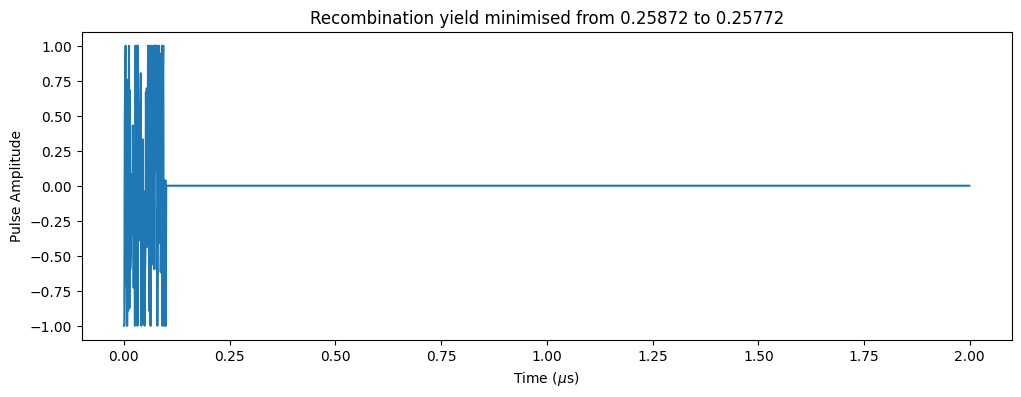

In [76]:
yield_max = float(dat["ys"])
yield_unpert = float(dat["ys0"])
t = np.arange(len(u_opt)) * 0.001
plt.figure(figsize=(12,4))
plt.plot(t, u_opt[:2000])
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Pulse Amplitude')
plt.title('Recombination yield minimised from {:.5} to {:.5}'.format(yield_unpert, yield_max));0.36566563410175623-0.315398664817067

### Plot !

Text(0, 0.5, 'Pulse Amplitude')

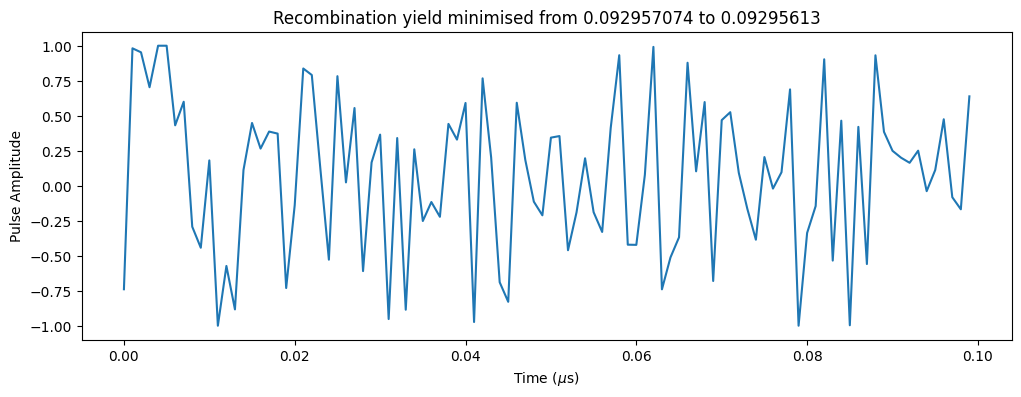

In [254]:
t = np.arange(len(generations[-1])) * 0.001

plt.figure(figsize=(12,4))
plt.plot(t,generations[-1])
plt.title("Recombination yield minimised from {:.8} to {:.8}".format(history[0], history[-1]))
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Pulse Amplitude")